# RSS Model Select for SBMs 

In [2]:
#%% 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed

from graspy.models import DCSBEstimator, RDPGEstimator, SBEstimator
from graspy.plot import heatmap, pairplot
from graspy.simulations import p_from_latent, sample_edges, sbm
from graspy.utils import binarize, is_fully_connected
from graspy.simulations import sbm 

# plotting stuff
sns.set_context("talk", font_scale=1)
plt.style.use("seaborn-white")
sns.set_palette("Set1")
savefig = False


In [3]:
def _n_to_labels(n):
    n_cumsum = n.cumsum()
    labels = np.zeros(n.sum(), dtype=np.int64)
    for i in range(1, len(n)):
        labels[n_cumsum[i - 1] : n_cumsum[i]] = i
    return labels

def gen_B(n_blocks, a=0.1, b=0.2, assortivity=4):
    B_mat = np.random.uniform(a, b, size=(n_blocks, n_blocks))
    B_mat -= np.diag(np.diag(B_mat))
    B_mat += np.diag(np.random.uniform(assortivity*a, assortivity*b, size=n_blocks))
    return B_mat

def gen_sbm(n_verts, n_blocks, B_mat):
    ps = np.array(n_blocks*[1/n_blocks])
    n_vec = np.random.multinomial(n_verts, ps)
    graph = sbm(n_vec, B_mat, directed=False, loops=False)
    labels = _n_to_labels(n_vec)
    return graph, labels
    
def compute_rss(estimator, graph):
    p_mat = estimator.p_mat_
    diff = (p_mat - graph)**2
    rss = np.sum(diff)
    return rss

def compute_log_lik(estimator, graph, c=0):
    p_mat = estimator.p_mat_
    p_mat[p_mat < c] = c
    p_mat[p_mat > 1 - c] = 1 - c
    successes = np.multiply(p_mat, graph)
    failures = np.multiply((1 - p_mat), (1 - graph))
    likelihood = successes + failures
    return np.sum(np.log(likelihood))

## Notation

$n$ - the number of vertices in the simulated graph

$K$ - the number of true communities in the SBM

Let B have $d$ on the main diagonal, $o$ elsewhere.

$$B = \begin{bmatrix} d & o & \dots & o \\
                      o & \ddots & & \\
                      \vdots & &\ddots & \\
                      o &   & & d
                      \end{bmatrix}$$

$d$ = 0.6

$o$ = 0.1

$B^K$ is a block probability matrix with $K$ blocks as described above 

$\eta$ is the number of parameters in a fit SBM

for a directed $B$
$$\eta = K^2 + (K-1)$$
for an undirected $B$
$$\eta = \frac{K(K+1)}{2} + (K-1)$$

## Setting up the simulation

100
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[200, 500, 1000, 1500, 2000]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

0.1
0.1
6


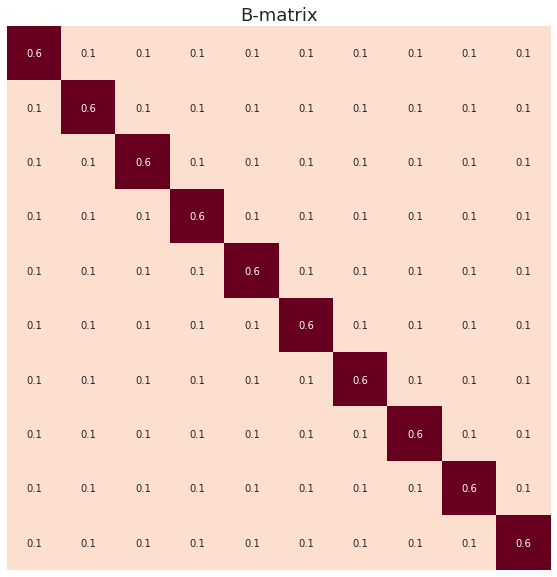

In [4]:
np.random.seed(8888)

# sim params
n_sims = 100
n_blocks_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_verts_range = [200, 500, 1000, 1500, 2000]
n_jobs=50
n_block_try_range = list(range(1,13))

print(n_sims)
print(n_blocks_range)
print(n_verts_range)
print(n_block_try_range)

print()
# B params 
a = 0.1
b = 0.1
assortivity = 6
print(a)
print(b)
print(assortivity)

B_mat = gen_B(n_blocks_range[-1], a=a, b=b, assortivity=assortivity)
plt.figure(figsize=(10,10))
sns.heatmap(B_mat,
            cbar=False,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            xticklabels=False,
            yticklabels=False);
plt.title("B-matrix");

## Residual sum of squares and penalty

$$RSS = \Sigma_{i, j} (A_{ij} - \hat{P_{ij}})^2$$
$$PRSS = \Sigma_{i, j} (A_{ij} - \hat{P_{ij}})^2 + \eta log(n^2) = \Sigma_{i, j} (A_{ij} - \hat{P_{ij}})^2 + 2 \eta log(n)$$

## Choosing a model with $PRSS$

- for 100 simulations
    - for $K$ in 1:6
        - generate $B^K$
        - for $n$ in [100, 200, 500, 1000, 2000]
            - generate graph from ($B^K$, $n$)
            - for $k$ in 1:8
                - fit a $k$-block SBM
                - compute $PRSS$
                
            - $\hat{K}$ = $argmin_k(PRSS)$

In [5]:
np.random.seed(8889)

def run_sim(seed):
    np.random.seed(seed)
    score_out = np.zeros((len(n_blocks_range),
                        len(n_verts_range),
                        len(n_block_try_range)))
    n_params_out = np.zeros_like(score_out)
    rss_out = np.zeros_like(score_out)
    
    for j, n_blocks in enumerate(n_blocks_range):
        B_mat_trunc = B_mat[:n_blocks,:n_blocks]
        for k, n_verts in enumerate((n_verts_range)):
            graph, labels = gen_sbm(n_verts, n_blocks, B_mat_trunc)
            for l, n_block_try in enumerate(n_block_try_range):
                estimator = SBEstimator(directed=False,
                                        loops=False,
                                        min_comm=n_block_try,
                                        max_comm=n_block_try)
                estimator.fit(graph)
                
                rss = compute_rss(estimator, graph)
                score = compute_log_lik(estimator, graph)
                n_params = estimator._n_parameters()
                
                rss_out[j,k,l] = rss
                score_out[j,k,l] = score
                n_params_out[j,k,l] = n_params
                
    return (rss_out, score_out, n_params_out)

seeds = np.random.randint(1e8, size=n_sims)
outs = Parallel(n_jobs=n_jobs, verbose=40)(delayed(run_sim)(seed)
                                      for seed in seeds)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   1 tasks      | elapsed: 27.6min
[Parallel(n_jobs=50)]: Done   4 out of 100 | elapsed: 30.9min remaining: 741.2min
[Parallel(n_jobs=50)]: Done   7 out of 100 | elapsed: 32.4min remaining: 430.2min
[Parallel(n_jobs=50)]: Done  10 out of 100 | elapsed: 33.1min remaining: 297.6min
[Parallel(n_jobs=50)]: Done  13 out of 100 | elapsed: 33.5min remaining: 224.4min
[Parallel(n_jobs=50)]: Done  16 out of 100 | elapsed: 33.9min remaining: 177.8min
[Parallel(n_jobs=50)]: Done  19 out of 100 | elapsed: 34.4min remaining: 146.4min
[Parallel(n_jobs=50)]: Done  22 out of 100 | elapsed: 34.8min remaining: 123.2min
[Parallel(n_jobs=50)]: Done  25 out of 100 | elapsed: 34.9min remaining: 104.6min
[Parallel(n_jobs=50)]: Done  28 out of 100 | elapsed: 35.0min remaining: 90.0min
[Parallel(n_jobs=50)]: Done  31 out of 100 | elapsed: 35.1min remaining: 78.2min
[Parallel(n_jobs=50)]: Done  34 out of 100 

# Results

Does $\hat{K}$ chosen using $PRSS$ match the true $K$? 

How does $n$ and $K$ affect this?

In [ ]:
# Format output
rss_out = []
n_params_out = []
score_out = []
for out in outs:
    rss_out.append(out[0])
    score_out.append(out[1])
    n_params_out.append(out[2])
rss_out = np.array(rss_out)
score_out = np.array(score_out)
n_params_out = np.array(n_params_out)
print(rss_out.shape)
print(score_out.shape)
print(n_params_out.shape)

In [5]:
n_verts_range = np.array(n_verts_range)

p_rss = rss_out + n_params_out * np.log(n_verts_range[np.newaxis,
                                                          np.newaxis,
                                                          :,
                                                          np.newaxis] * 
                                        (n_verts_range[np.newaxis,
                                                          np.newaxis,
                                                          :,
                                                          np.newaxis]-1)/2)**1.5
best_p_rss = np.argmin(p_rss, axis=3)
best_p_rss.shape

n_blocks_range = np.array(n_blocks_range)
expected_out = (np.zeros_like(best_p_rss)
                + n_blocks_range[np.newaxis,:,np.newaxis] - 1)
error = (expected_out - best_p_rss) != 0

sns.set_palette("Set1")


for i, K in enumerate(n_blocks_range):
    plt.figure(figsize=(10,5))
    wrong_by_n_verts = []
    for j, n_verts in enumerate(n_verts_range):
        wrong = error[:,i,j].sum() / n_sims
        wrong_by_n_verts.append(wrong)
    sns.barplot(x=n_verts_range, y=wrong_by_n_verts)
    plt.ylim(0, 1)
    plt.title(f"True K = {K}")
    plt.ylabel('Error')
    plt.xlabel('N Verts')
    plt.show()

plot_bins = np.arange(0.75, 12.25, 0.5)
hist_kws = {'histtype':"step", 'alpha':1}
for i, K in enumerate(n_blocks_range):
    plt.figure(figsize=(10,5))
    for j, n_verts in enumerate(n_verts_range):
        dist = best_p_rss[:,i,j] + 1
        sns.distplot(dist,
                     label=n_verts,
                     bins=plot_bins,
                     hist=True,
                     kde=False,
                     hist_kws=hist_kws)
        plt.axvline(K, color='k', linestyle='--', alpha=0.5)
#     sns.barplot(x=n_verts_range, y=wrong_by_n_verts)
    plt.legend()
    plt.title(f"True K = {K}")
    plt.xlabel("Predicted K")
    plt.ylabel('N Classified')
    plt.show()

ValueError: attempt to get argmin of an empty sequence

In [8]:
param_penalty =  n_params_out * np.log(n_verts_range[np.newaxis,
                                               np.newaxis,
                                                          :,
                                                          np.newaxis] * 
                                        (n_verts_range[np.newaxis,
                                                          np.newaxis,
                                                          :,
                                                          np.newaxis]-1)/2)

In [10]:
param_penalty = n_params

(100, 10, 5, 12)

In [16]:
p_score = 2*n_params_out - score_out

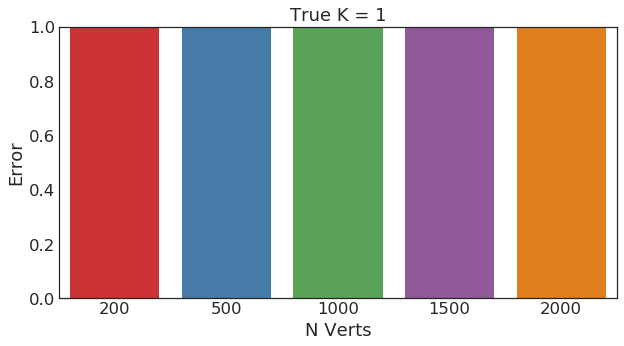

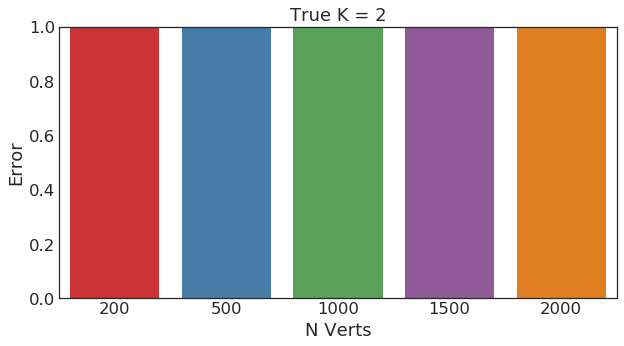

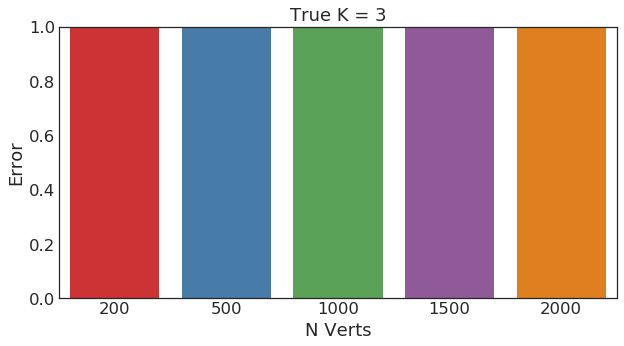

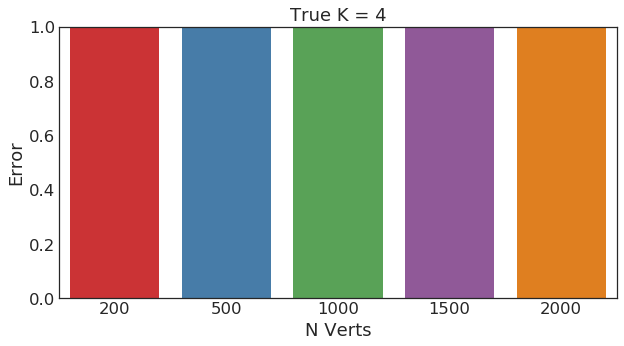

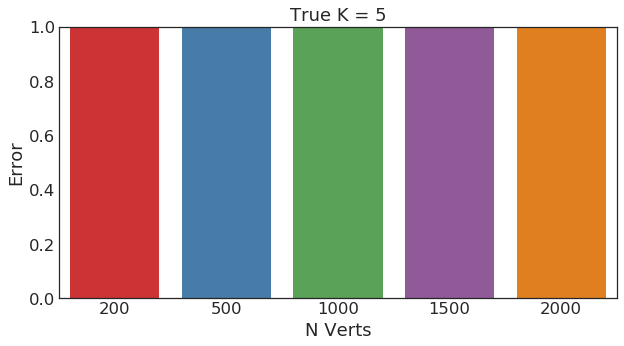

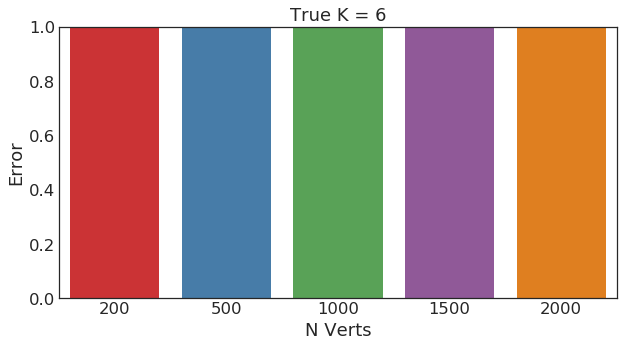

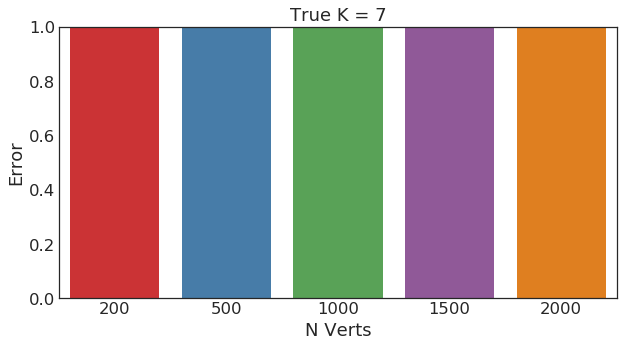

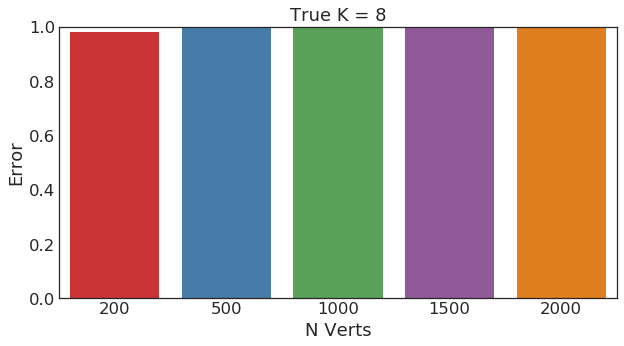

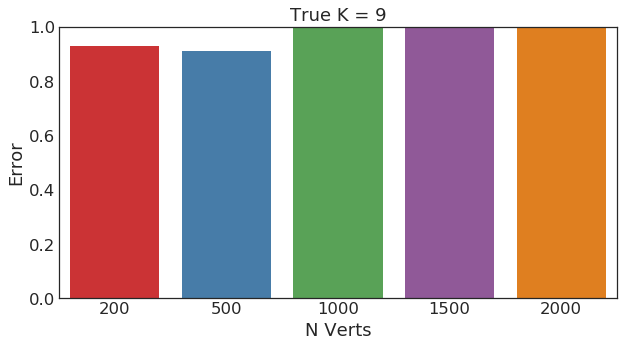

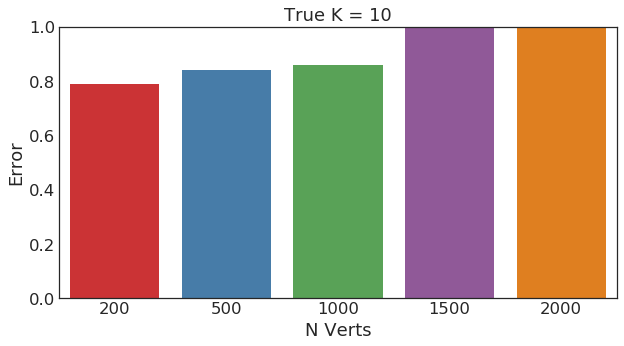

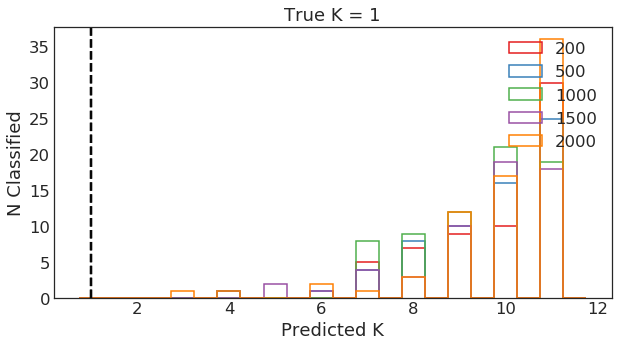

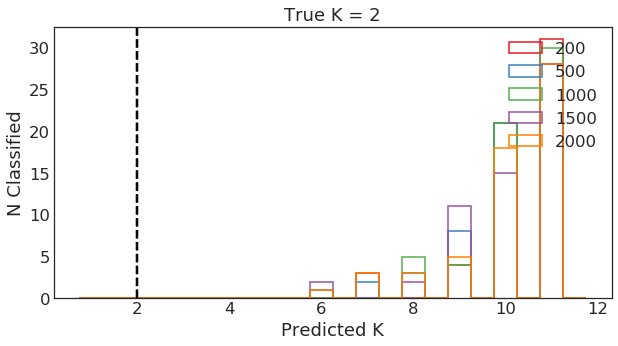

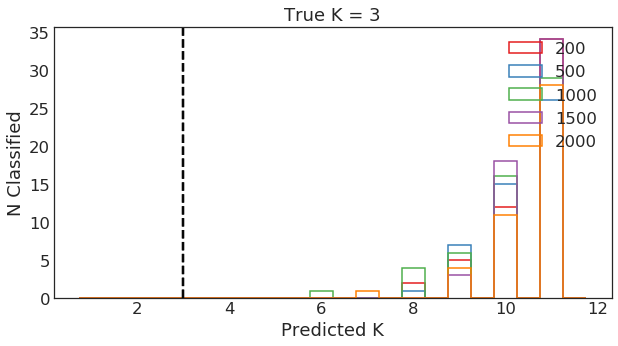

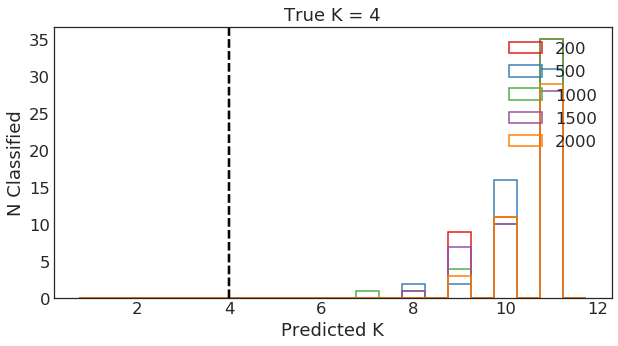

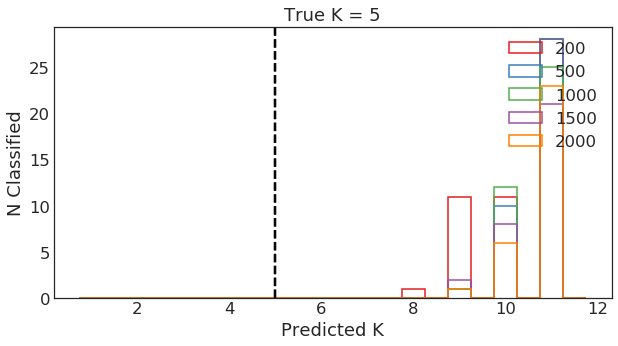

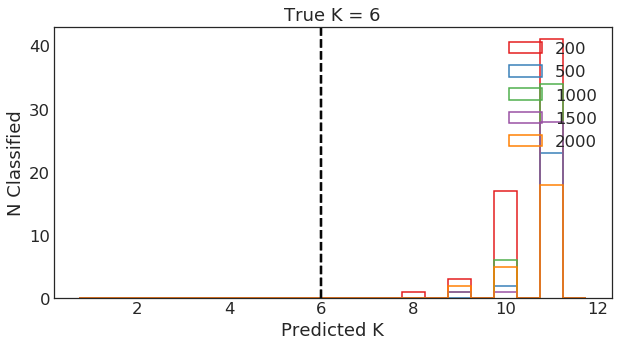

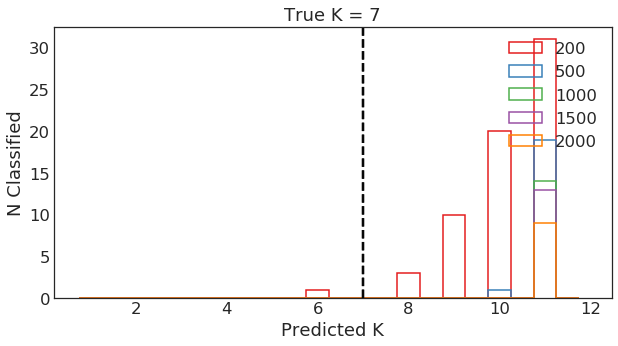

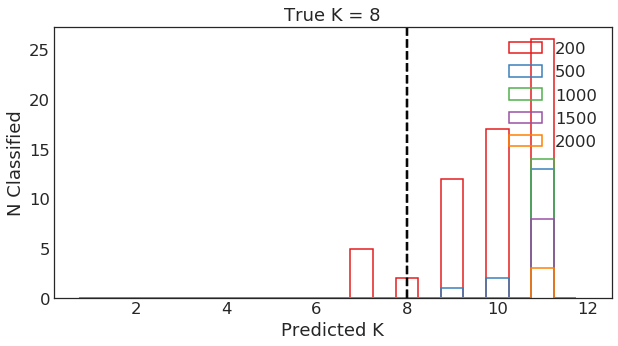

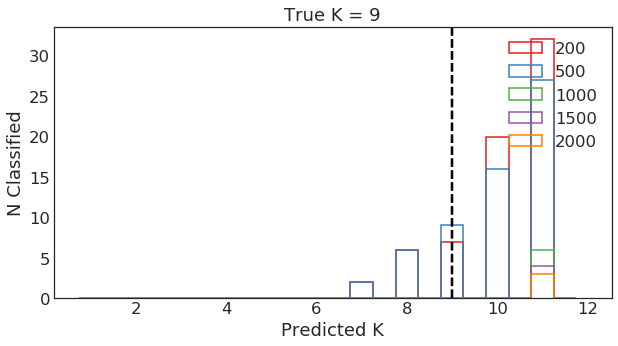

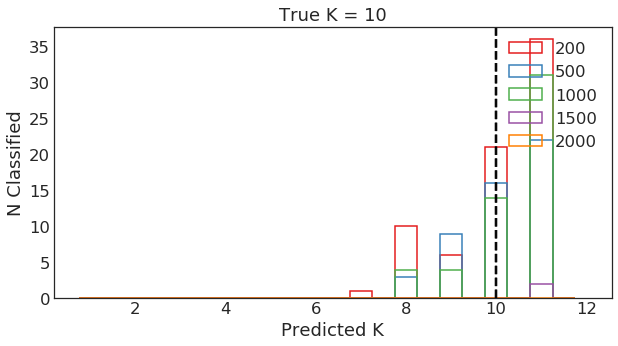

In [17]:
best_p_rss = np.argmin(p_score, axis=3)
best_p_rss.shape

n_blocks_range = np.array(n_blocks_range)
expected_out = (np.zeros_like(best_p_rss)
                + n_blocks_range[np.newaxis,:,np.newaxis] - 1)
error = (expected_out - best_p_rss) != 0

sns.set_palette("Set1")


for i, K in enumerate(n_blocks_range):
    plt.figure(figsize=(10,5))
    wrong_by_n_verts = []
    for j, n_verts in enumerate(n_verts_range):
        wrong = error[:,i,j].sum() / n_sims
        wrong_by_n_verts.append(wrong)
    sns.barplot(x=n_verts_range, y=wrong_by_n_verts)
    plt.ylim(0, 1)
    plt.title(f"True K = {K}")
    plt.ylabel('Error')
    plt.xlabel('N Verts')
    plt.show()

plot_bins = np.arange(0.75, 12.25, 0.5)
hist_kws = {'histtype':"step", 'alpha':1}
for i, K in enumerate(n_blocks_range):
    plt.figure(figsize=(10,5))
    for j, n_verts in enumerate(n_verts_range):
        dist = best_p_rss[:,i,j] + 1
        sns.distplot(dist,
                     label=n_verts,
                     bins=plot_bins,
                     hist=True,
                     kde=False,
                     hist_kws=hist_kws)
        plt.axvline(K, color='k', linestyle='--', alpha=0.5)
#     sns.barplot(x=n_verts_range, y=wrong_by_n_verts)
    plt.legend()
    plt.title(f"True K = {K}")
    plt.xlabel("Predicted K")
    plt.ylabel('N Classified')
    plt.show()

# JUNK

In [ ]:
# JUNK

def run_rss(adj, estimator, rangelist, kws):
    rss = np.zeros(len(rangelist))
    p_mse = np.zeros(len(rangelist))
    n_params = np.zeros(len(rangelist))
    for i, n in enumerate(rangelist):
        if estimator == "SBM":
            e = SBEstimator(min_comm=n, max_comm=n, **kws)
        elif estimator == "RDPG":
            e = RDPGEstimator(n_components=n, **kws)
        elif estimator == "DCSBM":
            e = DCSBEstimator(min_comm=n, max_comm=n, **kws)
        else:
            raise TypeError()
        e.fit(adj)
        rss[i] = e.mse(adj)
        p_mse[i] = e.mse(adj) + e._n_parameters() * np.log(adj.size)
        n_params[i] = e._n_parameters()
    return np.stack((mse, n_params), axis=1), np.stack((p_mse, n_params), axis=1)



for i, n_blocks in tqdm(enumerate(n_blocks_range)):
    for j, n_verts in enumerate(n_verts_range):
        B_mat_trunc = B_mat[:n_blocks,:n_blocks]
        for k in range(n_model_fits):
            graph, labels = gen_sbm(n_verts, n_blocks, B_mat_trunc)
            for l, n_block_try in enumerate(n_block_try_range):
                estimator = SBEstimator(directed=True, loops=False, min_comm=n_block_try, max_comm=n_block_try)
                estimator.fit(graph)
                rss = compute_rss(estimator, graph)
                n_params = estimator._n_parameters()
                rss_out[i,j,k,l] = rss
                n_params_out[i,j,k,l] = n_params